In [3]:
cd /home/nv/Downloads

/home/nv/Downloads


In [4]:
from __future__ import print_function
import time
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.preprocessing import sequence
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, merge, BatchNormalization
from keras.datasets import imdb

import os
from keras.preprocessing.text import Tokenizer

In [5]:
max_features = 10000
max_len = 200  # cut texts after this number of words (among top max_features most common words)

In [6]:
# read in the train data
X_train = []
y_train = []

path = './aclImdb/train/pos/'
X_train.extend([open(path + f).read() for f in os.listdir(path) if f.endswith('.txt')])
y_train.extend([1 for _ in range(12500)])

path = './aclImdb/train/neg/'
X_train.extend([open(path + f).read() for f in os.listdir(path) if f.endswith('.txt')])
y_train.extend([0 for _ in range(12500)])

print('x:')
print(X_train[:1])
print(X_train[-1:])
print(len(X_train))
print('y:')
print(y_train[:1])
print(y_train[-1:])
print(len(y_train))

x:
["Here's a gritty, get-the-bad guys revenge story starring a relentless and rough Denzel Washington. He's three personalities here: a down-and-out-low-key-now drunk- former mercenary, then a loving father-type person to a little girl and then a brutal maniac on the loose seeking answers and revenge.<br /><br />The story is about Washington hired to be a bodyguard for a little American girl living in Mexico, where kidnappings of children occur regularly (at least according to the movie.) He becomes attached to the kid, played winningly by THE child actress of our day, Dakota Fanning. When Fanning is kidnapped in front of him, Washington goes after the men responsible and spares no one. Beware: this film is not for the squeamish.<br /><br />This is stylish film-making, which is good and bad. I liked it, but a number of people found it too frenetic for their tastes as the camera-work is one that could give you a headache. I thought it fit the tense storyline and was fascinating to view

In [7]:
# read in the test data

X_test = []
y_test = []

path = './aclImdb/test/pos/'
X_test.extend([open(path + f).read() for f in os.listdir(path) if f.endswith('.txt')])
y_test.extend([1 for _ in range(12500)])

path = './aclImdb/test/neg/'
X_test.extend([open(path + f).read() for f in os.listdir(path) if f.endswith('.txt')])
y_test.extend([0 for _ in range(12500)])

print('x:')
print(X_test[:1])
print(X_test[-1:])
print(len(X_test))
print('y:')
print(y_test[:1])
print(y_test[-1:])
print(len(y_test))

x:
['A light, uplifting and engaging movie. Watching Irene Dunne is a delight! As you watch her, she ceases to be Irene Dunne and becomes in every way Paula Wharton.<br /><br />I have enjoyed Irene Dunne in every movie that I have seen and that would be nearly all of them. What a shame that most of her movies need restoration so badly. I do hope Irene Dunne movie are restored before it is too late they are such treasures Thank goodness this is not the case with Over 21.<br /><br />It is a must see if you like superb acting and witty comedy with serious overtones. I agree with a previous comment on the speech "The World and Apple Pie" it was one of the many highlights of the movie. I read somewhere that Irene Dunne helped in writing that speech along with Director Vidor (Irene Dunne was a very good and charitable person in private life) and it certainly seems to show through in her movies!']
["I have not figured out what the chosen title has to do with the movie. This is another gatheri

In [8]:
#tokenize works to list of integers where each integer is a key to a word
reviewTokenizer = Tokenizer(nb_words=max_features)

reviewTokenizer.fit_on_texts(X_train)

In [9]:
#print top 10 words 
#note zero is reserved for non frequent words
for word, value in reviewTokenizer.word_index.items():
    if value < 10:
        print(value, word)

9 it
6 is
8 in
4 of
2 and
3 a
7 br
1 the
5 to


In [10]:
#create int to word dictionary
wordDic = {}
for word, value in reviewTokenizer.word_index.items():
    wordDic[value] = word

#add a symbol for null placeholder
wordDic[0] = "!!!NA!!!"
    
print(wordDic[1])
print(wordDic[2])
print(wordDic[32])

the
and
an


In [11]:
#convert word strings to integer sequence lists
print(X_train[0])
print(reviewTokenizer.texts_to_sequences(X_train[:1]))
for value in reviewTokenizer.texts_to_sequences(X_train[:1])[0]:
    print(wordDic[value])
    
X_train = reviewTokenizer.texts_to_sequences(X_train)
X_test = reviewTokenizer.texts_to_sequences(X_test)

Here's a gritty, get-the-bad guys revenge story starring a relentless and rough Denzel Washington. He's three personalities here: a down-and-out-low-key-now drunk- former mercenary, then a loving father-type person to a little girl and then a brutal maniac on the loose seeking answers and revenge.<br /><br />The story is about Washington hired to be a bodyguard for a little American girl living in Mexico, where kidnappings of children occur regularly (at least according to the movie.) He becomes attached to the kid, played winningly by THE child actress of our day, Dakota Fanning. When Fanning is kidnapped in front of him, Washington goes after the men responsible and spares no one. Beware: this film is not for the squeamish.<br /><br />This is stylish film-making, which is good and bad. I liked it, but a number of people found it too frenetic for their tastes as the camera-work is one that could give you a headache. I thought it fit the tense storyline and was fascinating to view, but

In [12]:
# Censor the data by having a max review length (in number of words)

#use this function to load data from keras pickle instead of munging as shown above
#(X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=max_features,
#                                                      test_split=0.2)

print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print("Pad sequences (samples x time)")
X_train = sequence.pad_sequences(X_train, maxlen=max_len)
X_test = sequence.pad_sequences(X_test, maxlen=max_len)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
y_train = np.array(y_train)
y_test = np.array(y_test)

25000 train sequences
25000 test sequences
Pad sequences (samples x time)
X_train shape: (25000, 200)
X_test shape: (25000, 200)


In [13]:
#example of a sentence sequence, note that lower integers are words that occur more commonly
print("x:", X_train[0]) #per observation vector of 20000 words
print("y:", y_train[0]) #positive or negative review encoding

x: [ 177    2   43  361 1314  147 1816 1135   92    3 1711  333  549  412    5
    3  114  247    2   92    3 1767 5046   20    1 1885 2985 2754    2 1057
    7    7    1   62    6   41 2076 2630    5   27    3 8240   15    3  114
  295  247  578    8 2710  118    4  473 3914 6945   30  219 1790    5    1
   17   26  458 3461    5    1  551  253   31    1  503  520    4  260  248
 8820   51 8820    6 3528    8 1008    4   87 2076  268  100    1  346 1890
    2   54   28 5515   11   19    6   21   15    1    7    7   11    6 3003
   19  228   60    6   49    2   75   10  420    9   18    3  609    4   81
  255    9   96 9831   15   65 5178   14    1  367  154    6   28   12   97
  199   22    3 6254   10  194    9 1180    1 3091  766    2   13 1426    5
  647   18   42    1 5085  367   21   15   29 5178    7    7 1367    1  104
  378   47    6    1  207  218 1366 3586    8   32  361 1314  214    2    3
  609    4   82  475  153    7    7    1   19    5    1 2807 1435    8   29
    4  17

In [14]:
# double check that word sequences behave/final dimensions are as expected
print("y distribution:", np.unique(y_train, return_counts=True))
print("max x word:", np.max(X_train), "; min x word", np.min(X_train))
print("y distribution test:", np.unique(y_test, return_counts=True))
print("max x word test:", np.max(X_test), "; min x word", np.min(X_test))

y distribution: (array([0, 1]), array([12500, 12500]))
max x word: 9999 ; min x word 0
y distribution test: (array([0, 1]), array([12500, 12500]))
max x word test: 9999 ; min x word 0


In [15]:
print("most and least popular words: ")
print(np.unique(X_train, return_counts=True))
# as expected zero is the highly used word for words not in index

most and least popular words: 
(array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=int32), array([1084314,  232315,  115675, ...,      18,      21,      29]))


In [16]:
#set model hyper parameters
epochs = 6
embedding_neurons = 128
lstm_neurons = 64
batch_size = 32

In [17]:
# Forward Pass LSTM Network

# this is the placeholder tensor for the input sequences
sequence = Input(shape=(max_len,), dtype='int32')
# this embedding layer will transform the sequences of integers
# into vectors of size embedding
# embedding layer converts dense int input to one-hot in real time to save memory
embedded = Embedding(max_features, embedding_neurons, input_length=max_len)(sequence)
# normalize embeddings by input/word in sentence
bnorm = BatchNormalization()(embedded)

# apply forwards LSTM layer size lstm_neurons
forwards = LSTM(lstm_neurons, dropout_W=0.2, dropout_U=0.2)(bnorm)

# dropout 
after_dp = Dropout(0.5)(forwards)
output = Dense(1, activation='sigmoid')(after_dp)

model_fdir_atom = Model(input=sequence, output=output)
# review model structure
print(model_fdir_atom.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 200)           0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 200, 128)      1280000     input_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNormal(None, 200, 128)      256         embedding_1[0][0]                
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 64)            49408       batchnormalization_1[0][0]       
___________________________________________________________________________________________

In [18]:
# Forward pass LSTM network

# try using different optimizers and different optimizer configs
model_fdir_atom.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

print('Train...')
start_time = time.time()

history_fdir_atom = model_fdir_atom.fit(X_train, y_train,
                    batch_size=batch_size,
                    nb_epoch=epochs,
                    validation_data=[X_test, y_test], 
                    verbose=2)

end_time = time.time()
average_time_per_epoch = (end_time - start_time) / epochs
print("avg sec per epoch:", average_time_per_epoch)

Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/6
387s - loss: 0.5194 - acc: 0.7319 - val_loss: 0.3669 - val_acc: 0.8514
Epoch 2/6
405s - loss: 0.2996 - acc: 0.8808 - val_loss: 0.3170 - val_acc: 0.8678
Epoch 3/6
343s - loss: 0.2100 - acc: 0.9184 - val_loss: 0.3833 - val_acc: 0.8556
Epoch 4/6
349s - loss: 0.1695 - acc: 0.9362 - val_loss: 0.3743 - val_acc: 0.8681
Epoch 5/6
320s - loss: 0.1246 - acc: 0.9556 - val_loss: 0.4199 - val_acc: 0.8654
Epoch 6/6
350s - loss: 0.0975 - acc: 0.9648 - val_loss: 0.4894 - val_acc: 0.8600
avg sec per epoch: 368.793916345


In [20]:
# Bi-directional Atom

# based on keras tutorial: https://github.com/fchollet/keras/blob/master/examples/imdb_bidirectional_lstm.py

# this is the placeholder tensor for the input sequences
sequence = Input(shape=(max_len,), dtype='int32')
# this embedding layer will transform the sequences of integers
# into vectors of size embedding
# embedding layer converts dense int input to one-hot in real time to save memory
embedded = Embedding(max_features, embedding_neurons, input_length=max_len)(sequence)
# normalize embeddings by input/word in sentence
bnorm = BatchNormalization()(embedded)

# apply forwards LSTM layer size lstm_neurons
forwards = LSTM(lstm_neurons, dropout_W=0.4, dropout_U=0.4)(bnorm)
# apply backwards LSTM
backwards = LSTM(lstm_neurons, dropout_W=0.4, dropout_U=0.4, go_backwards=True)(bnorm)

# concatenate the outputs of the 2 LSTMs
merged = merge([forwards, backwards], mode='concat', concat_axis=-1)
after_dp = Dropout(0.5)(merged)
output = Dense(1, activation='sigmoid')(after_dp)

model_bidir_atom = Model(input=sequence, output=output)
# review model structure
print(model_bidir_atom.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 200)           0                                            
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 200, 128)      1280000     input_2[0][0]                    
____________________________________________________________________________________________________
batchnormalization_2 (BatchNormal(None, 200, 128)      256         embedding_2[0][0]                
____________________________________________________________________________________________________
lstm_2 (LSTM)                    (None, 64)            49408       batchnormalization_2[0][0]       
___________________________________________________________________________________________

In [21]:
# Bi-directional Atom

# try using different optimizers and different optimizer configs
model_bidir_atom.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

print('Train...')
start_time = time.time()

history_bidir_atom = model_bidir_atom.fit(X_train, y_train,
                    batch_size=batch_size,
                    nb_epoch=epochs,
                    validation_data=[X_test, y_test], 
                    verbose=2)

end_time = time.time()
average_time_per_epoch = (end_time - start_time) / epochs
print("avg sec per epoch:", average_time_per_epoch)

Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/6
635s - loss: 0.5909 - acc: 0.6729 - val_loss: 0.4145 - val_acc: 0.8260
Epoch 2/6
660s - loss: 0.3806 - acc: 0.8371 - val_loss: 0.4096 - val_acc: 0.8499
Epoch 3/6
656s - loss: 0.2828 - acc: 0.8862 - val_loss: 0.3524 - val_acc: 0.8632
Epoch 4/6
636s - loss: 0.2249 - acc: 0.9148 - val_loss: 0.3772 - val_acc: 0.8645
Epoch 5/6
606s - loss: 0.1830 - acc: 0.9317 - val_loss: 0.4205 - val_acc: 0.8641
Epoch 6/6
615s - loss: 0.1514 - acc: 0.9428 - val_loss: 0.4554 - val_acc: 0.8640
avg sec per epoch: 644.418573181


In [22]:
# run simple linear regression to compare performance

#based on grid search done by: 
#https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch08/ch08.ipynb

#the tfidf vectors capture co-occurance statistics, think of each number representing how many times 
#a word occured in a text and scaled by word frequency

tfidfTokenizer = Tokenizer(nb_words=max_features)
tfidfTokenizer.fit_on_sequences(X_train.tolist())
X_train_tfidf = np.asarray(tfidfTokenizer.sequences_to_matrix(X_train.tolist(), mode="tfidf"))
X_test_tfidf = np.asarray(tfidfTokenizer.sequences_to_matrix(X_test.tolist(), mode="tfidf"))

In [23]:
#check tfidf matrix
print(X_train_tfidf)
print(X_train_tfidf.shape, X_test_tfidf.shape)

[[ 0.          2.53756219  2.09414849 ...,  0.          0.          0.        ]
 [ 5.53114288  2.14733479  1.49183293 ...,  0.          0.          0.        ]
 [ 0.          2.48588573  2.09414849 ...,  0.          0.          0.        ]
 ..., 
 [ 5.20620903  1.94673033  1.69633644 ...,  0.          0.          0.        ]
 [ 0.          2.22946644  1.85496169 ...,  0.          0.          0.        ]
 [ 0.          2.78627629  1.49183293 ...,  0.          0.          0.        ]]
(25000, 10000) (25000, 10000)


In [24]:
from sklearn.linear_model import LogisticRegression

model_tfidf_reg = LogisticRegression(random_state=0, C=0.001, penalty='l2', verbose=1)
model_tfidf_reg.fit(X_train_tfidf, y_train)

[LibLinear]

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=1, warm_start=False)

In [25]:
from sklearn.metrics import accuracy_score
#calculate test and train accuracy
print("train acc:", accuracy_score(y_test, model_tfidf_reg.predict(X_train_tfidf)))
print("test acc:", accuracy_score(y_test, model_tfidf_reg.predict(X_test_tfidf)))

train acc: 0.9352
test acc: 0.88188


In [26]:
#get weights from embedding layer and visualize

print(model_bidir_atom.layers[1].get_config())
embmatrix = model_bidir_atom.layers[1].get_weights()[0]
print(embmatrix.shape)

{'W_constraint': None, 'activity_regularizer': None, 'name': 'embedding_2', 'output_dim': 128, 'trainable': True, 'init': 'uniform', 'input_dtype': 'int32', 'mask_zero': False, 'batch_input_shape': (None, 200), 'W_regularizer': None, 'dropout': 0.0, 'input_dim': 10000, 'input_length': 200}
(10000, 128)


In [27]:
from sklearn.manifold import TSNE
topnwords = 5000
toptsne = TSNE(n_components=2, random_state=0)
tsneXY = toptsne.fit_transform(embmatrix[:topnwords, :]) 
tsneXY.shape

(5000, 2)

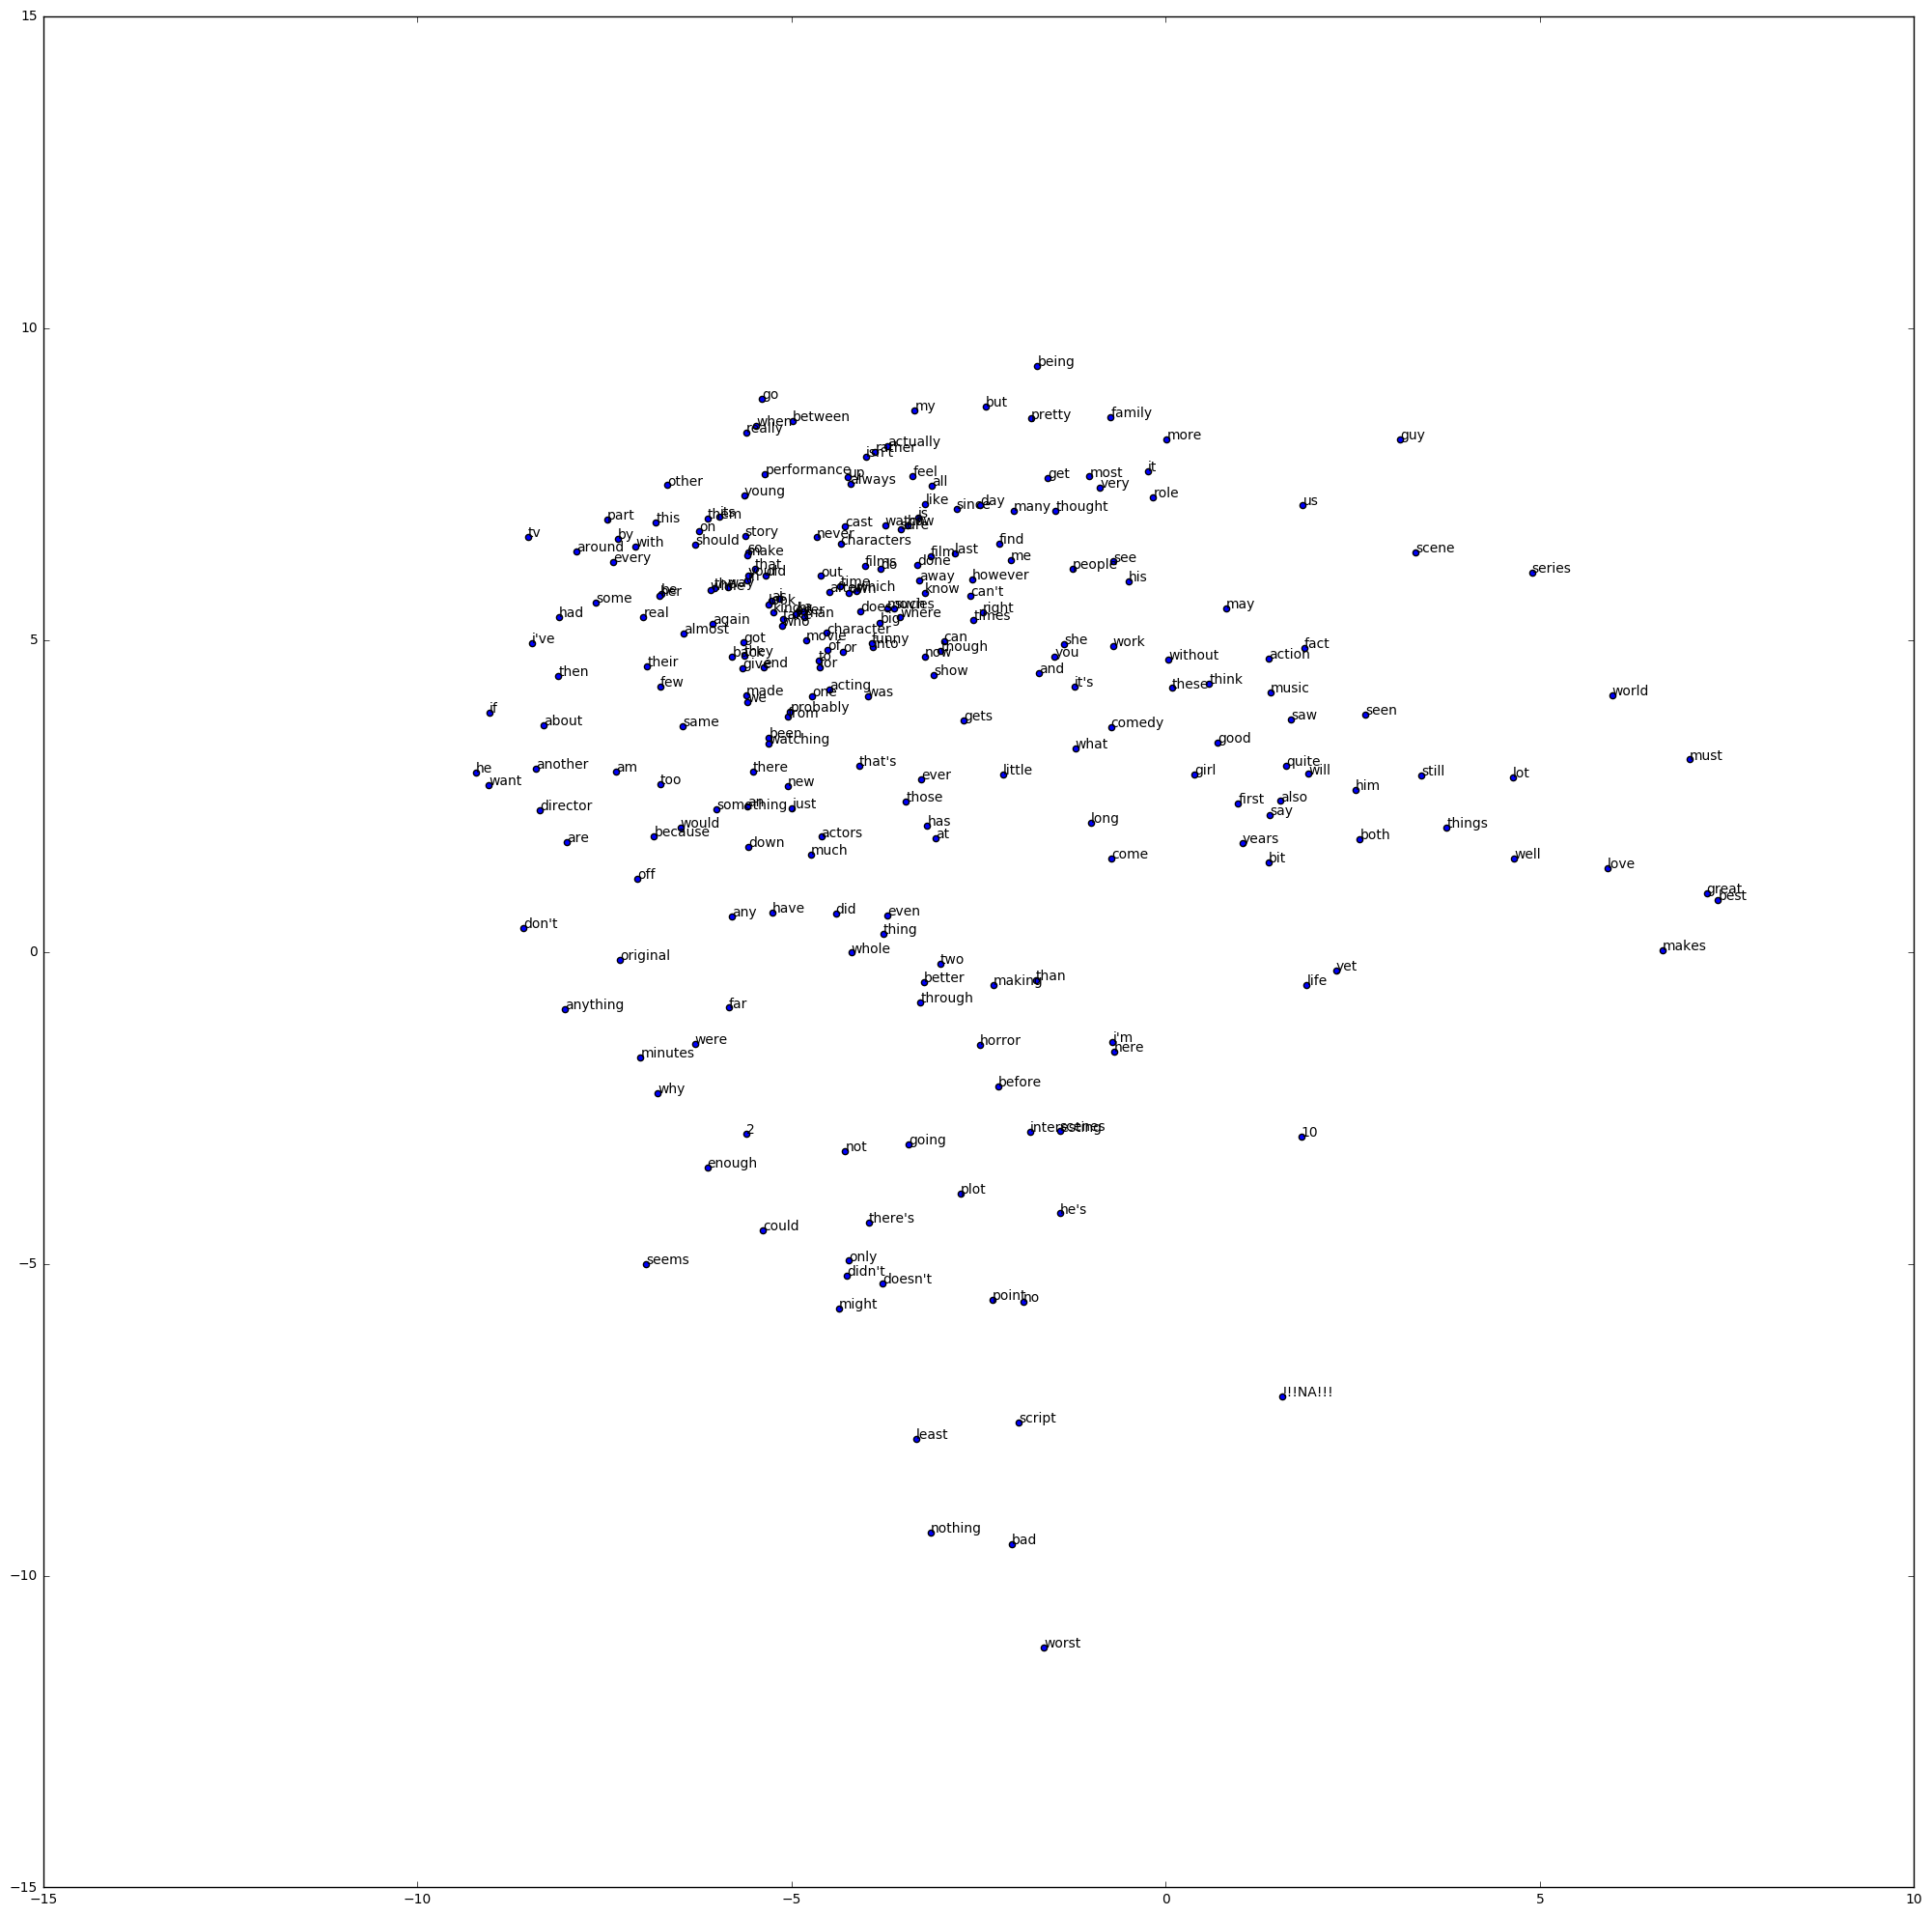

In [28]:
%matplotlib inline
displaytopnwords = 250
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(tsneXY[:displaytopnwords, 0], tsneXY[:displaytopnwords, 1])

for i in range(displaytopnwords):
    ax.annotate(wordDic[i], (tsneXY[i, 0], tsneXY[i, 1]))

fig.set_size_inches(25, 25)
plt.show()

In [29]:
# Bi-directional rmsprop

# this example illistrate's that choice of optimizer is an important hyper-parameter for RNNs
# rmsprop gives substancially better results than atom
# in the literature these two optimizers commonly do well on RNNs

# this is the placeholder tensor for the input sequences
sequence = Input(shape=(max_len,), dtype='int32')
# this embedding layer will transform the sequences of integers
# into vectors of size embedding
# embedding layer converts dense int input to one-hot in real time to save memory
embedded = Embedding(max_features, embedding_neurons, input_length=max_len)(sequence)
# normalize embeddings by input/word in sentence
bnorm = BatchNormalization()(embedded)

# apply forwards LSTM layer size lstm_neurons
forwards = LSTM(lstm_neurons, dropout_W=0.4, dropout_U=0.4)(bnorm)
# apply backwards LSTM
backwards = LSTM(lstm_neurons, dropout_W=0.4, dropout_U=0.4, go_backwards=True)(bnorm)

# concatenate the outputs of the 2 LSTMs
merged = merge([forwards, backwards], mode='concat', concat_axis=-1)
after_dp = Dropout(0.5)(merged)
output = Dense(1, activation='sigmoid')(after_dp)

model_bidir_rmsprop = Model(input=sequence, output=output)
# review model structure
print(model_bidir_rmsprop.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 200)           0                                            
____________________________________________________________________________________________________
embedding_3 (Embedding)          (None, 200, 128)      1280000     input_3[0][0]                    
____________________________________________________________________________________________________
batchnormalization_3 (BatchNormal(None, 200, 128)      256         embedding_3[0][0]                
____________________________________________________________________________________________________
lstm_4 (LSTM)                    (None, 64)            49408       batchnormalization_3[0][0]       
___________________________________________________________________________________________

In [31]:
# Bi-directional rmsprop

model_bidir_rmsprop.compile('rmsprop', 'binary_crossentropy', metrics=['accuracy'])

print('Train...')
start_time = time.time()

history_bidir_rmsprop = model_bidir_rmsprop.fit(X_train, y_train,
                    batch_size=batch_size,
                    nb_epoch=epochs,
                    validation_data=[X_test, y_test], 
                    verbose=2)

end_time = time.time()
average_time_per_epoch = (end_time - start_time) / epochs
print("avg sec per epoch:", average_time_per_epoch)

Train...


INFO (theano.gof.compilelock): Refreshing lock /home/nv/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-jessie-sid-x86_64-2.7.12-64/lock_dir/lock


Train on 25000 samples, validate on 25000 samples
Epoch 1/6
721s - loss: 0.5745 - acc: 0.6842 - val_loss: 0.5299 - val_acc: 0.7867
Epoch 2/6
605s - loss: 0.3705 - acc: 0.8439 - val_loss: 0.3479 - val_acc: 0.8684
Epoch 3/6
573s - loss: 0.2817 - acc: 0.8889 - val_loss: 0.3336 - val_acc: 0.8798
Epoch 4/6
610s - loss: 0.2387 - acc: 0.9077 - val_loss: 0.3566 - val_acc: 0.8770
Epoch 5/6
584s - loss: 0.2112 - acc: 0.9218 - val_loss: 0.3495 - val_acc: 0.8809
Epoch 6/6
592s - loss: 0.1857 - acc: 0.9309 - val_loss: 0.3884 - val_acc: 0.8770
avg sec per epoch: 620.017516812


In [32]:
#get weights from embedding layer and visualize

print(model_bidir_rmsprop.layers[1].get_config())
embmatrix = model_bidir_rmsprop.layers[1].get_weights()[0]
print(embmatrix.shape)

{'W_constraint': None, 'activity_regularizer': None, 'name': 'embedding_3', 'output_dim': 128, 'trainable': True, 'init': 'uniform', 'input_dtype': 'int32', 'mask_zero': False, 'batch_input_shape': (None, 200), 'W_regularizer': None, 'dropout': 0.0, 'input_dim': 10000, 'input_length': 200}
(10000, 128)


In [33]:
from sklearn.manifold import TSNE
topnwords = 5000
toptsne = TSNE(n_components=2, random_state=0)
tsneXY = toptsne.fit_transform(embmatrix[:topnwords, :]) 
tsneXY.shape

(5000, 2)

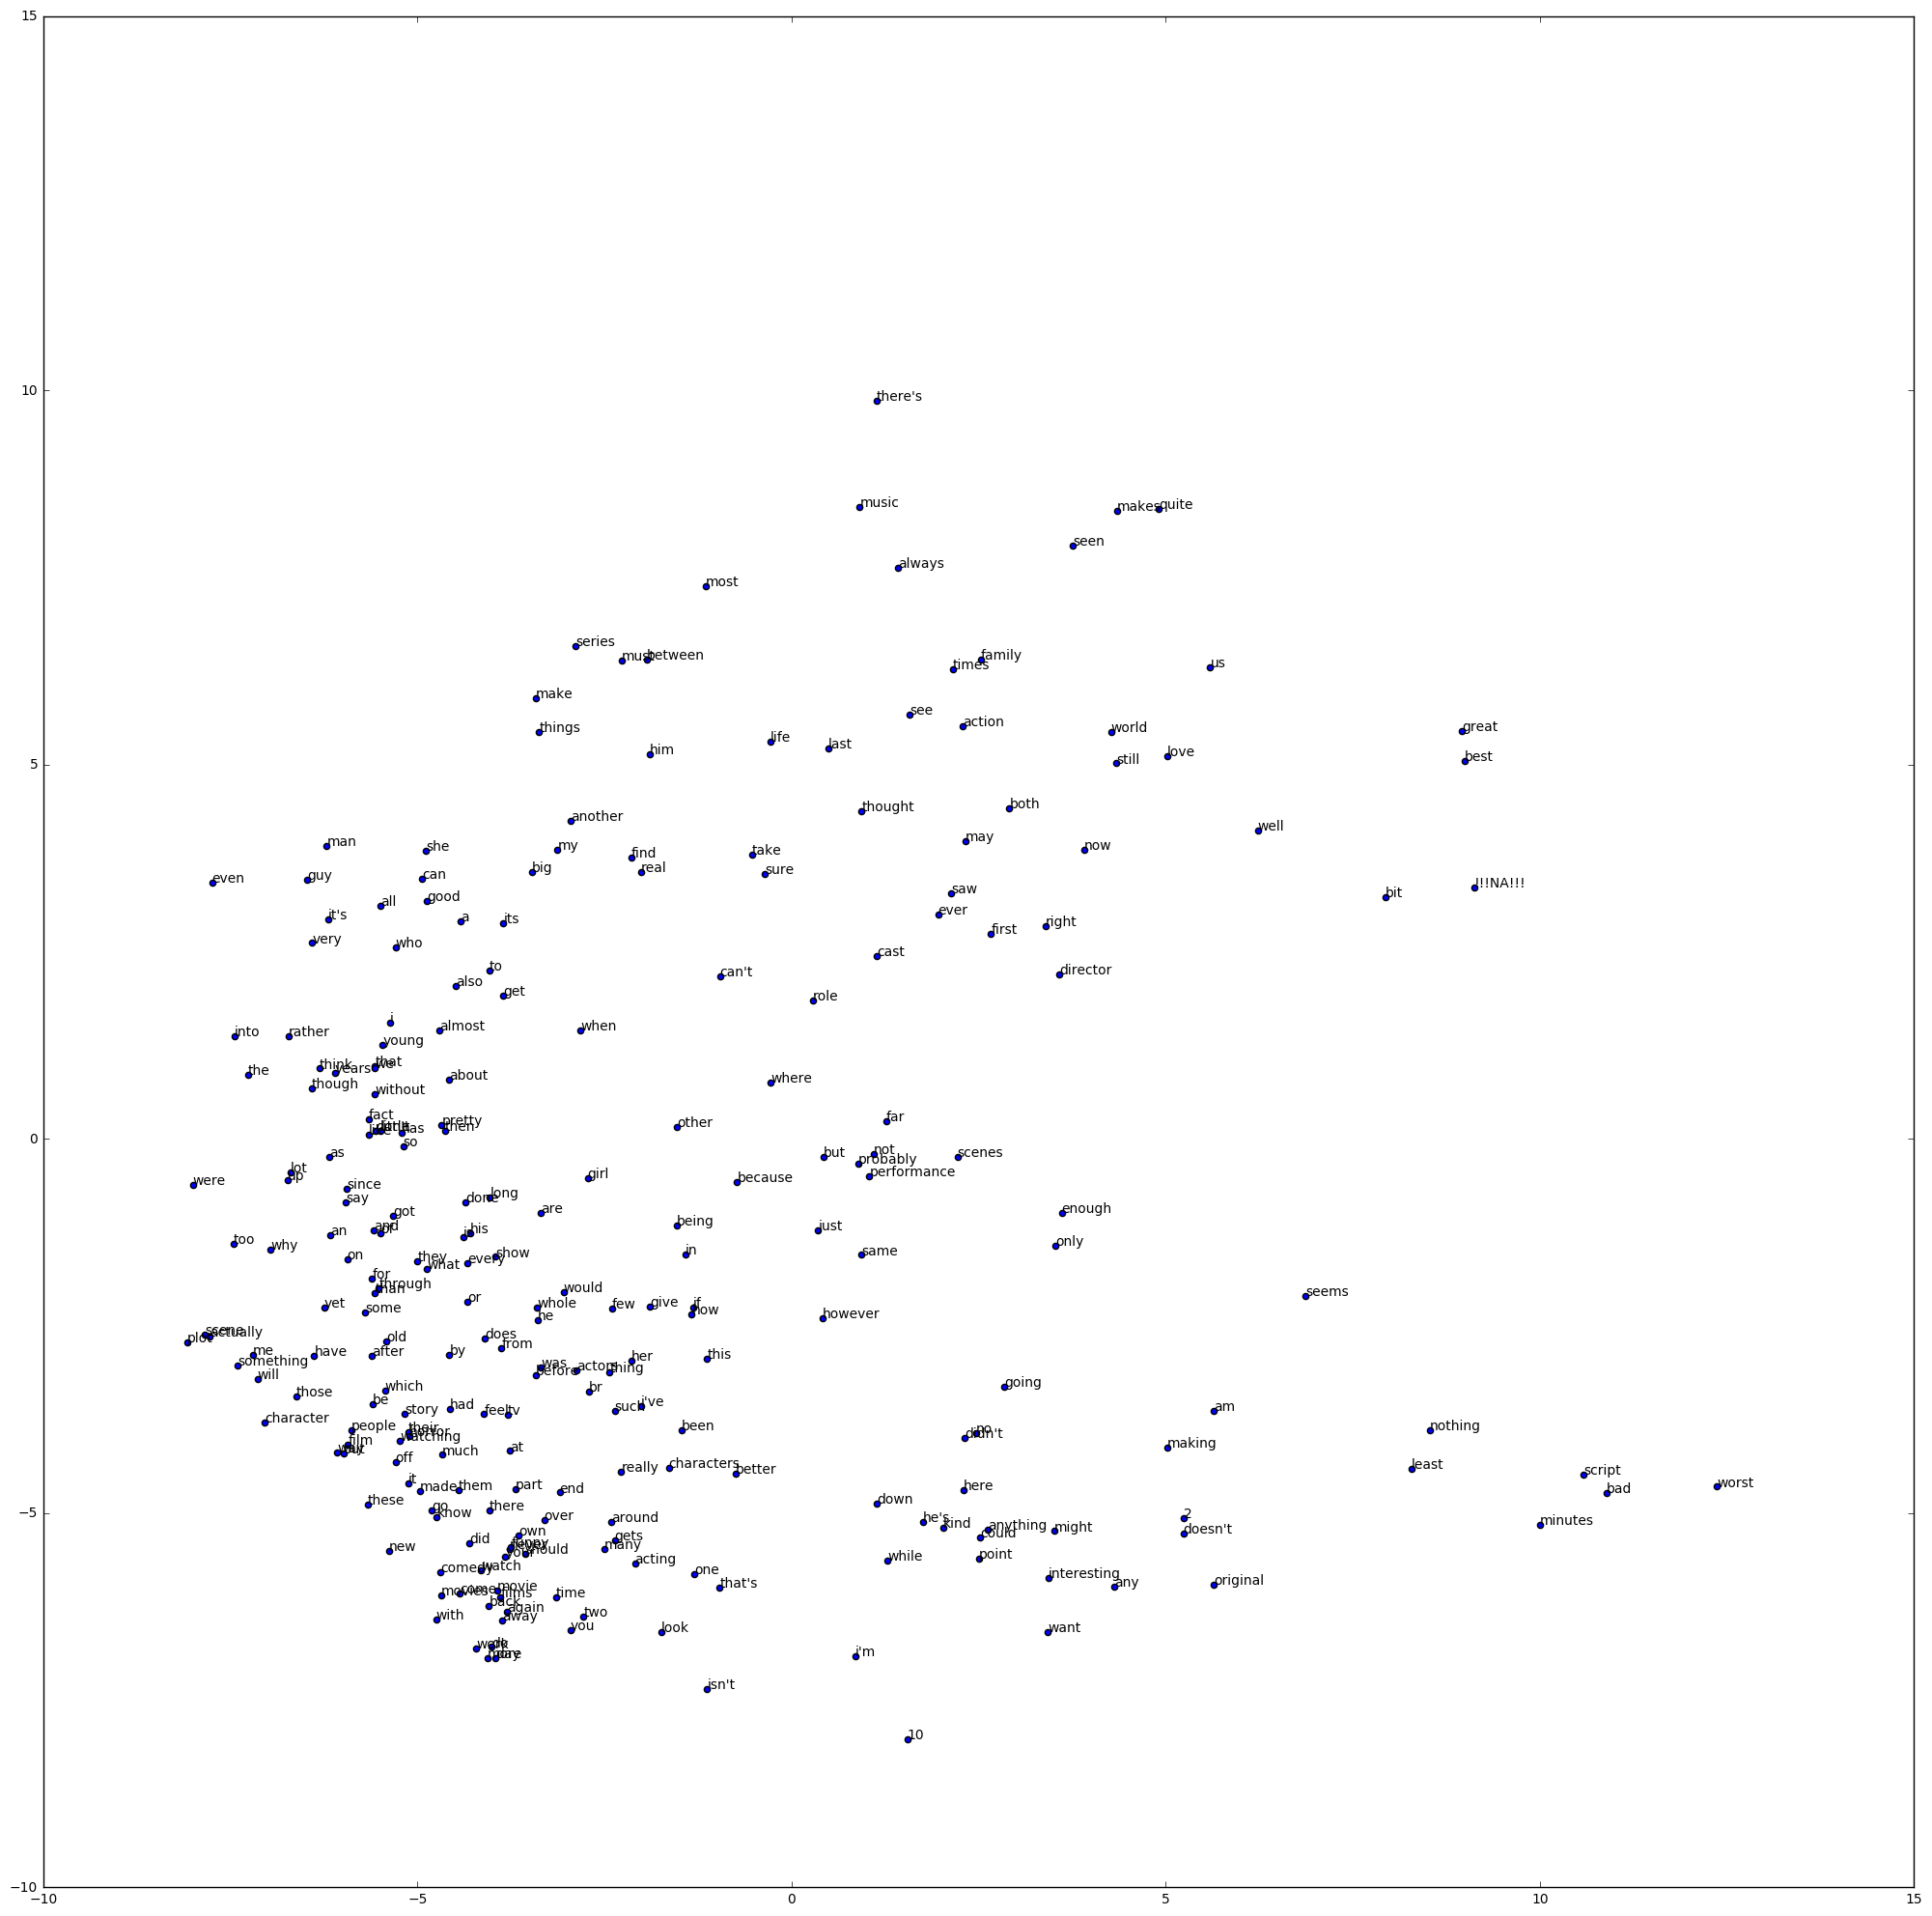

In [35]:
%matplotlib inline
displaytopnwords = 250
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(tsneXY[:displaytopnwords, 0], tsneXY[:displaytopnwords, 1])

for i in range(displaytopnwords):
    ax.annotate(wordDic[i], (tsneXY[i, 0], tsneXY[i, 1]))

fig.set_size_inches(25, 25)
plt.show()
# notice that great, most, well are clustered
# bad don't even are clustered
# We've learned structure in our sentiment embedding
# neural networks give us this and other useful features for free

In [37]:
#guide to chart above

for i in range(displaytopnwords):
    print((tsneXY[i, 0], tsneXY[i, 1], wordDic[i]))

(9.1211692360485888, 3.3552482852105676, '!!!NA!!!')
(-7.2644603398758392, 0.85623484414007378, 'the')
(-5.582567206511027, -1.2177951558293023, 'and')
(-4.4273495051914242, 2.911185050237155, 'a')
(-5.4973410617344447, -1.2591324915722879, 'of')
(-4.0366726879824721, 2.2548322902151607, 'to')
(-4.383855036639976, -1.3105004141292329, 'is')
(-2.7085226486866909, -3.3754355804585705, 'br')
(-1.4218316898014791, -1.5408734940116677, 'in')
(-5.1257651545397094, -4.5989591637595684, 'it')
(-5.3667350166442764, 1.549921539891653, 'i')
(-1.1325155048811215, -2.9399067570314772, 'this')
(-5.5702449759336261, 0.97744084617167037, 'that')
(-3.3528798064274206, -3.0532338222347368, 'was')
(-6.177514726109627, -0.23510272792882372, 'as')
(-5.6075017891167018, -1.8646128990918505, 'for')
(-4.7523456620900024, -6.4140369557827013, 'with')
(-3.9327567671782688, -6.0279587395764072, 'movie')
(0.42985409846709755, -0.24456759763656638, 'but')
(-5.9316355864741155, -4.0784487974359163, 'film')
(-5.9401

In [38]:
# Lets see what the embedding learned, 
# provoking is close to great in cosine space, that's cool and definettly movie specific

from scipy.spatial.distance import euclidean

for value in np.argsort(np.apply_along_axis(lambda x: euclidean(x, embmatrix[reviewTokenizer.word_index['great'],:]), 
                                            1, embmatrix))[:20]:
    print((wordDic[value], euclidean(embmatrix[value,:], embmatrix[reviewTokenizer.word_index['great'],:])))

('great', 0.0)
('wonderful', 0.5050570964813232)
('courage', 0.5211796164512634)
('sweet', 0.525455892086029)
('touched', 0.5273863077163696)
('favourite', 0.5292160511016846)
('keeper', 0.53465735912323)
('tremendous', 0.5355396270751953)
('cried', 0.538032054901123)
('stone', 0.5390382409095764)
('underrated', 0.5393837690353394)
('prince', 0.5457939505577087)
('steals', 0.5471921563148499)
('unique', 0.5480167269706726)
('wonderfully', 0.5497465133666992)
('absorbing', 0.5497508645057678)
('impact', 0.5505578517913818)
('terrific', 0.5513530373573303)
('unforgettable', 0.5517123937606812)
('chavez', 0.5537125468254089)


In [39]:
from scipy.spatial.distance import cosine

for value in np.argsort(np.apply_along_axis(lambda x: cosine(x, embmatrix[reviewTokenizer.word_index['great'],:]), 
                                            1, embmatrix))[:20]:
    print((wordDic[value], cosine(embmatrix[value,:], embmatrix[reviewTokenizer.word_index['great'],:])))

('great', -4.968141431582751e-08)
('wonderful', 0.22880693842383337)
('gem', 0.24017793216085392)
('excellent', 0.27010345380361955)
('favourite', 0.27908294232026432)
('terrific', 0.28615594423807988)
('courage', 0.2861641785088691)
('favorite', 0.29017409763723823)
('wonderfully', 0.29305467770506521)
('unforgettable', 0.29309888019949715)
('touched', 0.29871607709852777)
('perfect', 0.299027911919717)
('underrated', 0.2993400818958184)
('cried', 0.29983298338034214)
('delightful', 0.30433546962950253)
('amazing', 0.30735002923320831)
('sweet', 0.30837306478078952)
('today', 0.31421591438039453)
('crafted', 0.31456208191961121)
('prince', 0.31530052864802272)


In [40]:
reviewTokenizer.word_index['great']

84